In [1]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark


In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [3]:
print(spark.sparkContext)
print("Spark App Name : "+ spark.sparkContext.appName)

<SparkContext master=local[*] appName=pyspark-shell>
Spark App Name : pyspark-shell


In [4]:
# SparkContext stop() method
spark.sparkContext.stop()

In [5]:

# Create SparkContext
from pyspark import SparkContext
sc = SparkContext("local", "Group_Project_1")
print(sc.appName)


Group_Project_1


In [6]:
import pyspark.sql.functions as F
from pyspark.sql.types import *
import numpy as np
import scipy.stats as stats

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import pandas as pd



In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.appName("Group_Project_1").getOrCreate()

# Load the dataset
df = spark.read.csv("/content/drive/MyDrive/DataSet/ttc-bus-delay-data-2022.csv", header=True, inferSchema=True)
df.show(5)

# Count the total number of records
total_records = df.count()
print("Total Records:", total_records)

+--------+-----+-----+--------+--------------------+--------------------+---------+-------+---------+-------+
|    Date|Route| Time|     Day|            Location|            Incident|Min Delay|Min Gap|Direction|Vehicle|
+--------+-----+-----+--------+--------------------+--------------------+---------+-------+---------+-------+
|1-Jan-22|  320|02:00|Saturday|    YONGE AND DUNDAS|       General Delay|        0|      0|     null|   8531|
|1-Jan-22|  325|02:00|Saturday|OVERLEA AND THORC...|           Diversion|      131|    161|        W|   8658|
|1-Jan-22|  320|02:00|Saturday|   YONGE AND STEELES|Operations - Oper...|       17|     20|        S|      0|
|1-Jan-22|  320|02:07|Saturday|   YONGE AND STEELES|Operations - Oper...|        4|     11|        S|      0|
|1-Jan-22|  320|02:13|Saturday|   YONGE AND STEELES|Operations - Oper...|        4|      8|        S|      0|
+--------+-----+-----+--------+--------------------+--------------------+---------+-------+---------+-------+
only showi

# Data Cleaning

In [9]:
from pyspark.sql import functions as F

# Count missing values in PySpark DataFrame
for column in df.columns:
    null_count = df.filter(F.col(column).isNull()).count()
    print(f"{column} has {null_count} null values")



Date has 0 null values
Route has 164 null values
Time has 0 null values
Day has 0 null values
Location has 0 null values
Incident has 0 null values
Min Delay has 0 null values
Min Gap has 0 null values
Direction has 5577 null values
Vehicle has 0 null values


In [10]:
#fill null values of Router with unknown and Direction with N/A
df = df.na.fill({'Route': 'Unknown'})
df = df.na.fill({'Direction': 'N/A'})

In [11]:
from pyspark.sql import functions as F

# Count missing values in PySpark DataFrame
for column in df.columns:
    null_count = df.filter(F.col(column).isNull()).count()
    print(f"{column} has {null_count} null values")


Date has 0 null values
Route has 0 null values
Time has 0 null values
Day has 0 null values
Location has 0 null values
Incident has 0 null values
Min Delay has 0 null values
Min Gap has 0 null values
Direction has 0 null values
Vehicle has 0 null values


# Data preprocessing

In [12]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# Drop the column if it already exists
if "IncidentIndex" in df.columns:
    df = df.drop("IncidentIndex")

# Indexing for categorical variables
stringIndexer = StringIndexer(inputCol="Incident", outputCol="IncidentIndex")

# One-hot encoding
encoder = OneHotEncoder(inputCol="IncidentIndex", outputCol="IncidentVec")

# Assemble all the features into a single vector column.
# You can add more feature columns in the list besides "IncidentVec".
assembler = VectorAssembler(inputCols=["IncidentVec"], outputCol="features")

# Define the pipeline
pipeline = Pipeline(stages=[stringIndexer, encoder, assembler])
pipeline_model = pipeline.fit(df)

# Transform the data
df_transformed = pipeline_model.transform(df)

# Show transformed dataframe
df_transformed.show()


+--------+-----+-----+--------+--------------------+--------------------+---------+-------+---------+-------+-------------+--------------+--------------+
|    Date|Route| Time|     Day|            Location|            Incident|Min Delay|Min Gap|Direction|Vehicle|IncidentIndex|   IncidentVec|      features|
+--------+-----+-----+--------+--------------------+--------------------+---------+-------+---------+-------+-------------+--------------+--------------+
|1-Jan-22|  320|02:00|Saturday|    YONGE AND DUNDAS|       General Delay|        0|      0|      N/A|   8531|          5.0|(14,[5],[1.0])|(14,[5],[1.0])|
|1-Jan-22|  325|02:00|Saturday|OVERLEA AND THORC...|           Diversion|      131|    161|        W|   8658|          4.0|(14,[4],[1.0])|(14,[4],[1.0])|
|1-Jan-22|  320|02:00|Saturday|   YONGE AND STEELES|Operations - Oper...|       17|     20|        S|      0|          0.0|(14,[0],[1.0])|(14,[0],[1.0])|
|1-Jan-22|  320|02:07|Saturday|   YONGE AND STEELES|Operations - Oper...|   

In [13]:

from pyspark.sql.functions import mean, stddev, count, min, max


# Show the schema of the dataset
df.printSchema()

# Summary statistics for numerical columns
df.select("Min Delay", "Min Gap").summary().show()



# Calculate the average and standard deviation of Min Delay
avg_delay = df.select(mean("Min Delay")).collect()[0][0]
stddev_delay = df.select(stddev("Min Delay")).collect()[0][0]
print("Average Min Delay:", avg_delay)
print("Standard Deviation of Min Delay:", stddev_delay)

# Find the route with the most delays
most_delayed_route = df.groupBy("Route").agg(count("*").alias("DelayCount"))
most_delayed_route = most_delayed_route.orderBy(most_delayed_route.DelayCount.desc()).first()
print("Most Delayed Route:", most_delayed_route["Route"])






root
 |-- Date: string (nullable = true)
 |-- Route: string (nullable = false)
 |-- Time: string (nullable = true)
 |-- Day: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Incident: string (nullable = true)
 |-- Min Delay: integer (nullable = true)
 |-- Min Gap: integer (nullable = true)
 |-- Direction: string (nullable = false)
 |-- Vehicle: integer (nullable = true)

+-------+-----------------+-----------------+
|summary|        Min Delay|          Min Gap|
+-------+-----------------+-----------------+
|  count|            27351|            27351|
|   mean|20.29841687689664|32.87671383130416|
| stddev|49.63673608669362|51.29391319860774|
|    min|                0|                0|
|    25%|                9|               17|
|    50%|               11|               22|
|    75%|               20|               36|
|    max|              999|              999|
+-------+-----------------+-----------------+

Average Min Delay: 20.29841687689664
Standard Deviat

In [ ]:
#Data Scaling
#from pyspark.ml.feature import StandardScaler

#scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
#scalerModel = scaler.fit(df_transformed)
#df_scaled = scalerModel.transform(df_transformed)


# Data Transformation

In [14]:
from pyspark.sql import SparkSession

# Create or retrieve a Spark session
spark = SparkSession.builder.getOrCreate()

# Set the time parser policy to LEGACY
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

from pyspark.sql import functions as F

# Concatenate 'Date' and 'Time' columns and create a new 'Datetime' column
df = df.withColumn('Datetime', F.concat(F.col('Date'), F.lit(' '), F.col('Time')))

# Convert 'Datetime' to a timestamp type
df = df.withColumn('Datetime', F.to_timestamp('Datetime', 'dd-MMM-yy HH:mm'))

# Show the DataFrame to check if everything worked as expected
df.show()


+--------+-----+-----+--------+--------------------+--------------------+---------+-------+---------+-------+-------------------+
|    Date|Route| Time|     Day|            Location|            Incident|Min Delay|Min Gap|Direction|Vehicle|           Datetime|
+--------+-----+-----+--------+--------------------+--------------------+---------+-------+---------+-------+-------------------+
|1-Jan-22|  320|02:00|Saturday|    YONGE AND DUNDAS|       General Delay|        0|      0|      N/A|   8531|2022-01-01 02:00:00|
|1-Jan-22|  325|02:00|Saturday|OVERLEA AND THORC...|           Diversion|      131|    161|        W|   8658|2022-01-01 02:00:00|
|1-Jan-22|  320|02:00|Saturday|   YONGE AND STEELES|Operations - Oper...|       17|     20|        S|      0|2022-01-01 02:00:00|
|1-Jan-22|  320|02:07|Saturday|   YONGE AND STEELES|Operations - Oper...|        4|     11|        S|      0|2022-01-01 02:07:00|
|1-Jan-22|  320|02:13|Saturday|   YONGE AND STEELES|Operations - Oper...|        4|      8

# Feature Engineering

In [15]:
# Create new features
df = df.withColumn('Hour_of_Day', F.hour('Datetime'))
df = df.withColumn('Day_of_Month', F.dayofmonth('Datetime'))
df = df.withColumn('Week_of_Year', F.weekofyear('Datetime'))


# Distribution Analysis

/content/spark-3.0.0-bin-hadoop3.2/python/pyspark/sql/pandas/conversion.py:175: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


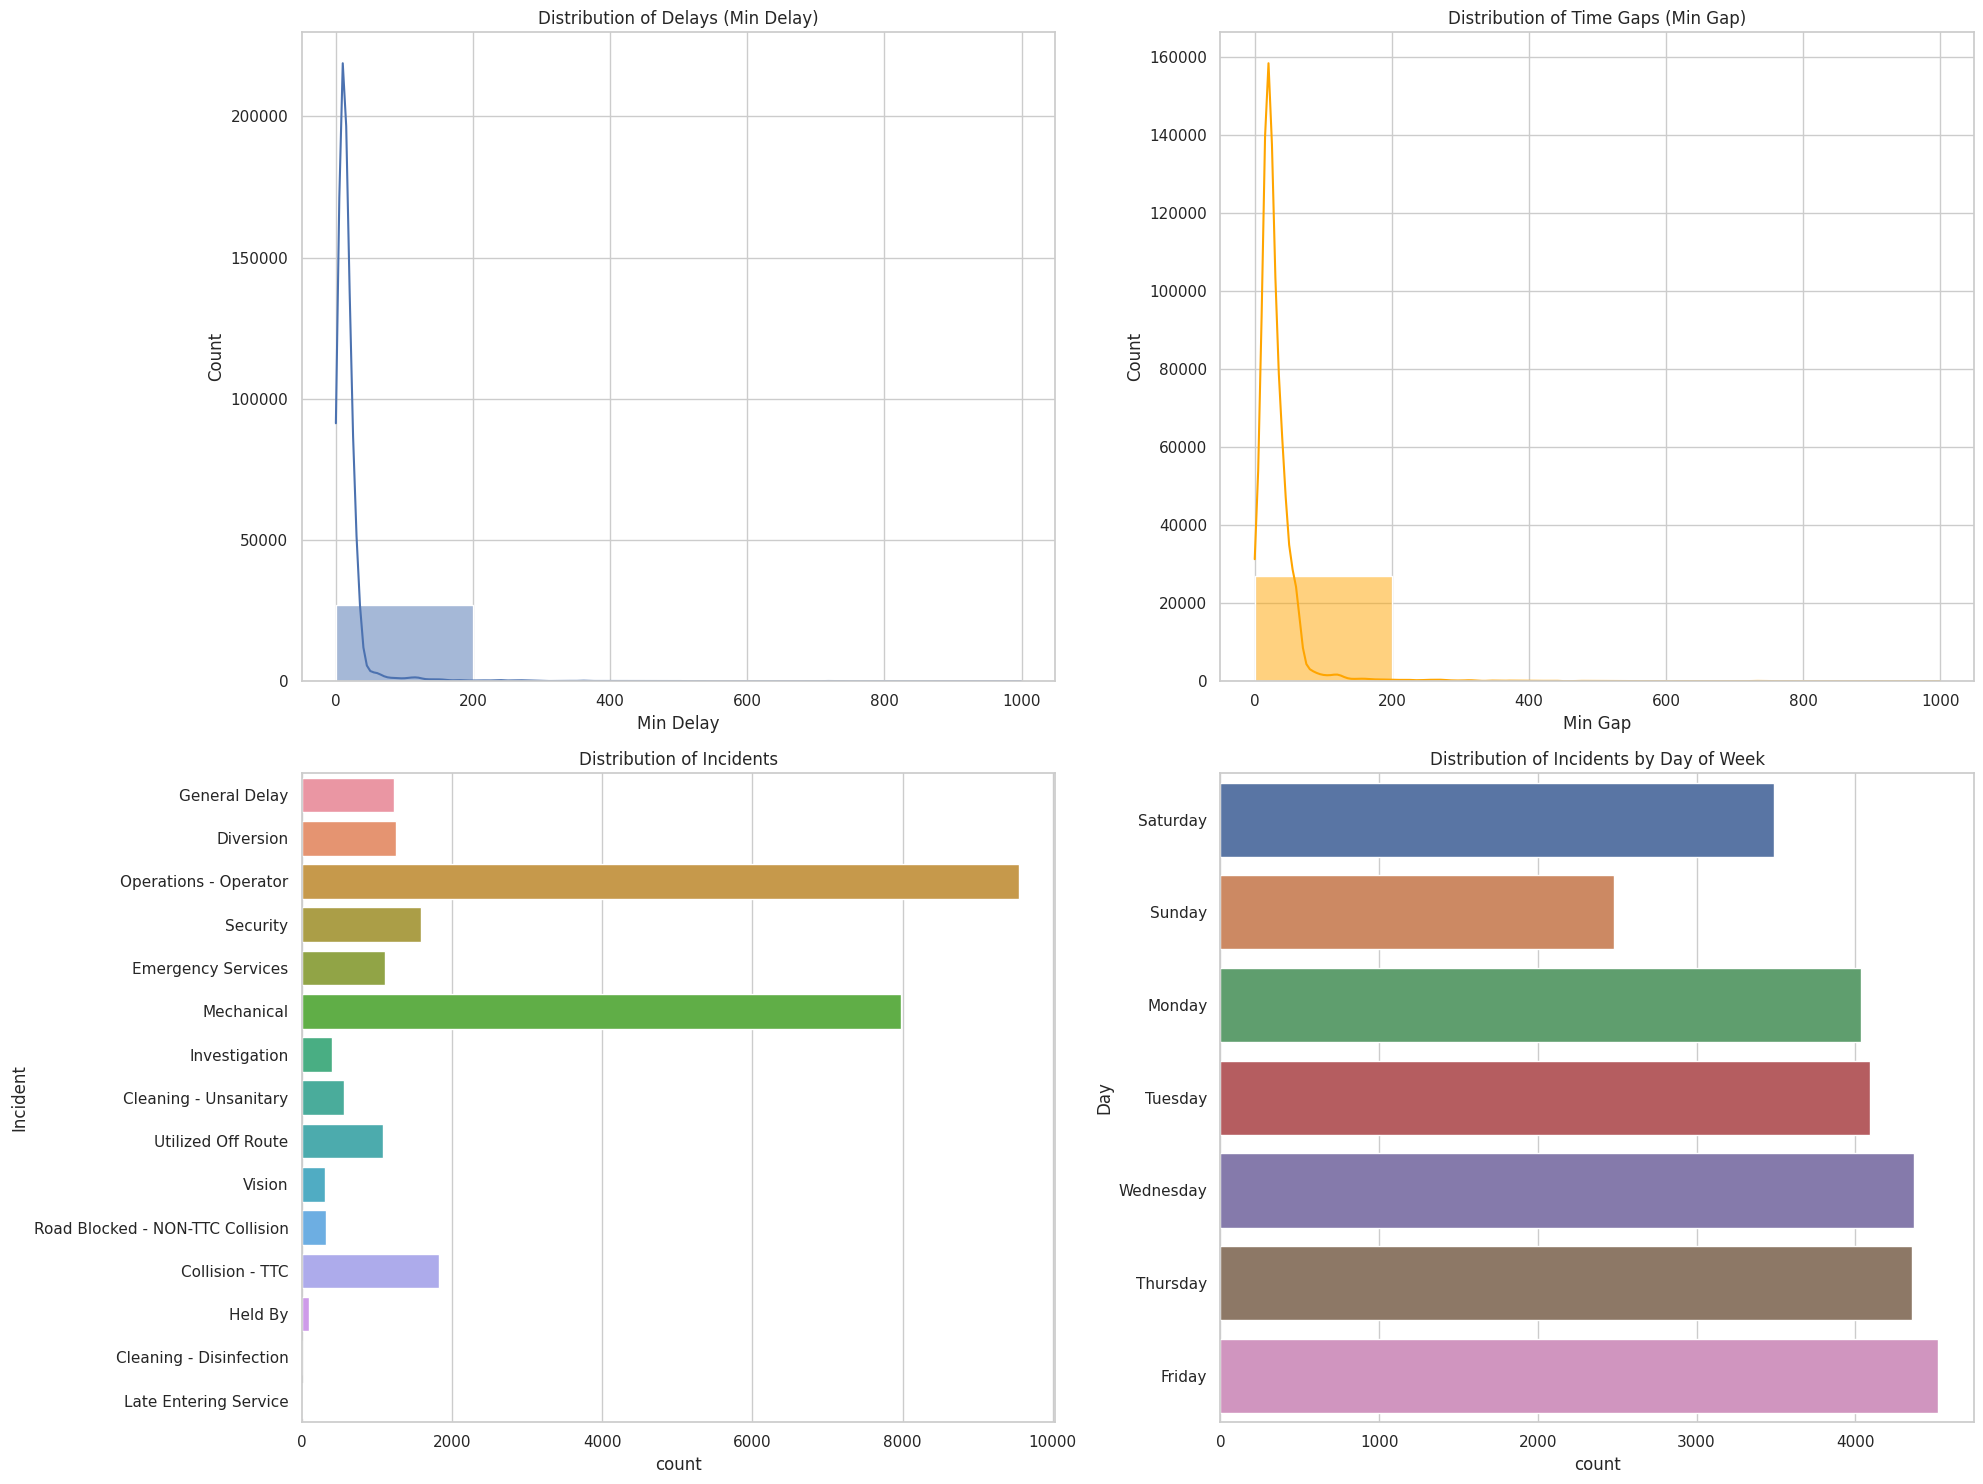

In [16]:
pdf = df.toPandas()

# Importing necessary libraries for EDA
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up the aesthetics for the plots
sns.set_style("whitegrid")

# Initialize the figure
plt.figure(figsize=(20, 15))

# Create subplots for distribution analysis
plt.subplot(2, 2, 1)
sns.histplot(pdf['Min Delay'], bins=5, kde=True)
plt.title('Distribution of Delays (Min Delay)')

plt.subplot(2, 2, 2)
sns.histplot(pdf['Min Gap'], bins=5, kde=True, color='orange')
plt.title('Distribution of Time Gaps (Min Gap)')

plt.subplot(2, 2, 3)
sns.countplot(data=pdf, y='Incident')
plt.title('Distribution of Incidents')

plt.subplot(2, 2, 4)
sns.countplot(data=pdf, y='Day')
plt.title('Distribution of Incidents by Day of Week')

plt.tight_layout()
plt.show()


# Train & Test

In [ ]:
#(train_data, test_data) = df.randomSplit([0.8, 0.2], seed=12345)

# Kmeans

In [17]:
# Define the feature columns to be used in the clustering
feature_cols = ["Min Delay", "Min Gap", "Hour_of_Day", "Day_of_Month", "Week_of_Year"]

# Assemble features to a single vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_for_clustering")
df = assembler.transform(df)


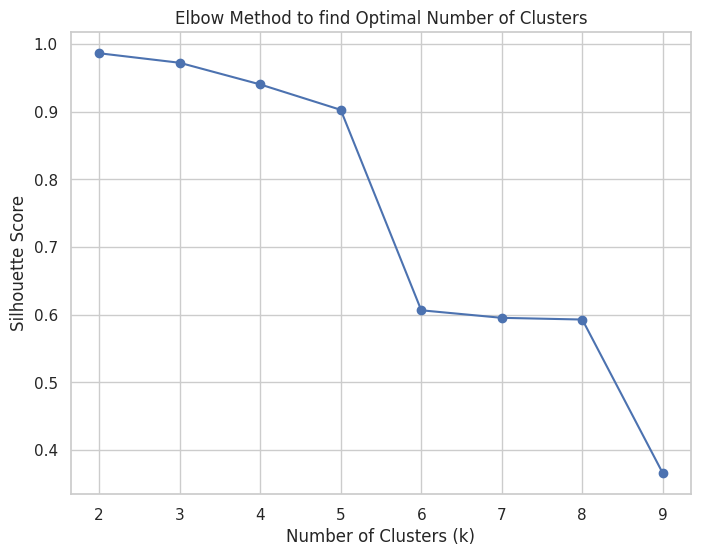

In [18]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Compute cost for a range of k values
cost = []
for k in range(2, 10):
    kmeans = KMeans(featuresCol='features_for_clustering').setK(k).setSeed(1)
    model = kmeans.fit(df)
    predictions = model.transform(df)
    evaluator = ClusteringEvaluator(featuresCol='features_for_clustering')
    silhouette = evaluator.evaluate(predictions)
    cost.append(silhouette)

# Plot the cost against k values
plt.figure(figsize=(8, 6))
plt.plot(range(2, 10), cost, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Elbow Method to find Optimal Number of Clusters')
plt.show()


In [21]:
kmeans = KMeans(featuresCol='features_for_clustering').setK(6).setSeed(1)
model = kmeans.fit(df)

# Make predictions
predictions = model.transform(df)


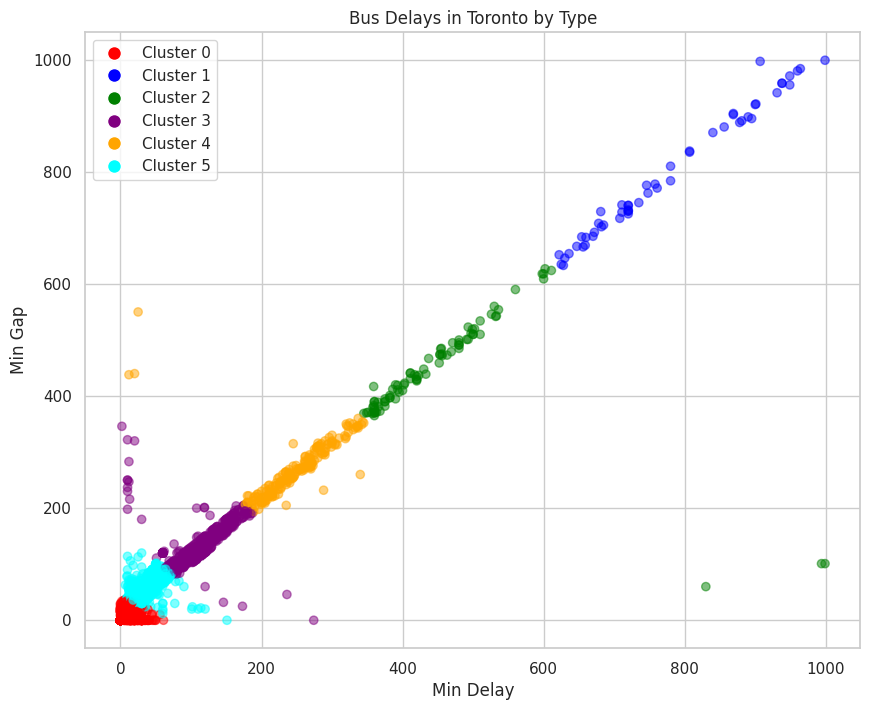

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# Collect the relevant columns for the scatter plot
delay_types = predictions.select("Min Delay", "Min Gap", "Incident", "prediction").toPandas()

# Define a color map for different types of bus delays
color_map = {
    0: 'red',  # Cluster 0
    1: 'blue',  # Cluster 1
    2: 'green',  # Cluster 2
    3: 'purple',  # Cluster 3
    4: 'orange',  # Cluster 4
    5: 'cyan'  # Cluster 5
}

# Map colors based on cluster predictions
colors = delay_types['prediction'].map(color_map)

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(delay_types["Min Delay"], delay_types["Min Gap"], c=colors, alpha=0.5)
plt.xlabel("Min Delay")
plt.ylabel("Min Gap")
plt.title("Bus Delays in Toronto by Type")
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Cluster 0'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Cluster 1'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Cluster 2'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=10, label='Cluster 3'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Cluster 4'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='cyan', markersize=10, label='Cluster 5')
])
plt.show()



In [23]:
evaluator = ClusteringEvaluator(featuresCol='features_for_clustering')
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette Score: {silhouette}")


Silhouette Score: 0.6067008326539577


In [24]:
from pyspark.sql.functions import mean, stddev

# Calculate mean and standard deviation for each feature within each cluster
cluster_stats = predictions.groupBy("prediction").agg(
    mean("Min Delay").alias("Mean_Min_Delay"),
    stddev("Min Delay").alias("StdDev_Min_Delay"),
    mean("Min Gap").alias("Mean_Min_Gap"),
    stddev("Min Gap").alias("StdDev_Min_Gap"),
    mean("Hour_of_Day").alias("Mean_Hour_of_Day"),
    stddev("Hour_of_Day").alias("StdDev_Hour_of_Day"),
    mean("Day_of_Month").alias("Mean_Day_of_Month"),
    stddev("Day_of_Month").alias("StdDev_Day_of_Month"),
    mean("Week_of_Year").alias("Mean_Week_of_Year"),
    stddev("Week_of_Year").alias("StdDev_Week_of_Year")
)

# Show the cluster statistics
cluster_stats.show()


+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+
|prediction|    Mean_Min_Delay|  StdDev_Min_Delay|      Mean_Min_Gap|    StdDev_Min_Gap|  Mean_Hour_of_Day|StdDev_Hour_of_Day| Mean_Day_of_Month|StdDev_Day_of_Month| Mean_Week_of_Year|StdDev_Week_of_Year|
+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+
|         1|  776.811320754717|112.46966370533565| 796.2830188679245|113.88006129231728|10.339622641509434|3.5999113035356385| 16.39622641509434|   9.02632820535722|11.641509433962264|   8.20434767392978|
|         3|109.71482176360225| 35.62404603413588|131.28142589118198|37.556368314448775|11.887429643527204| 6.657751118793511|16.429643527204504|   8.51608513788441|13.129455909943

In [ ]:
########################

In [ ]:
from pyspark.ml.clustering import BisectingKMeans



# Define a range of k values for BisectingKMeans
k_values = list(range(2, 10))

best_k = 0
best_silhouette = -1

for k in k_values:
    bkm = BisectingKMeans(featuresCol="features_for_clustering", k=k, seed=1)
    model = bkm.fit(df)
    predictions = model.transform(df)

    evaluator = ClusteringEvaluator(featuresCol="features_for_clustering")
    silhouette = evaluator.evaluate(predictions)

    if silhouette > best_silhouette:
        best_silhouette = silhouette
        best_k = k

print(f"Best Number of Clusters (k) for BisectingKMeans: {best_k}")
print(f"Best Silhouette Score: {best_silhouette}")

# Use the best k value to create the final BisectingKMeans model
best_bkm = BisectingKMeans(featuresCol="features_for_clustering", k=best_k, seed=1)
best_model = best_bkm.fit(df)
best_predictions = best_model.transform(df)



Best Number of Clusters (k) for BisectingKMeans: 2
Best Silhouette Score: 0.9859857412662212


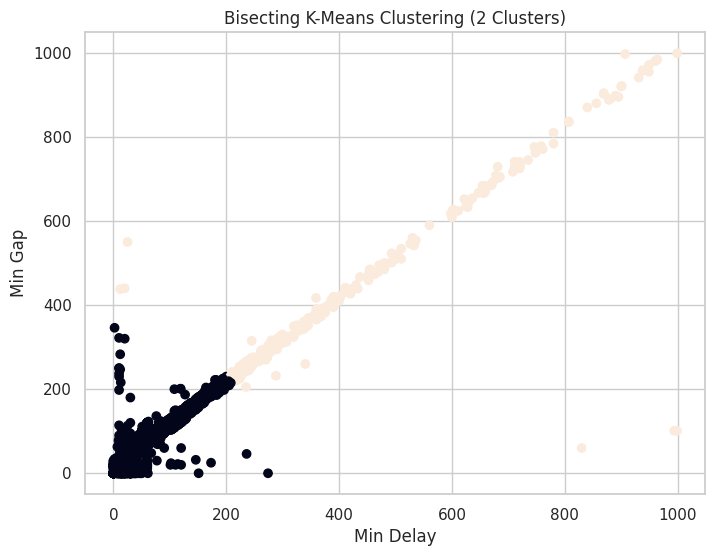

In [ ]:
from pyspark.sql.functions import col

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(
    best_predictions.select(col("Min Delay")).collect(),
    best_predictions.select(col("Min Gap")).collect(),
    c=best_predictions.select(col("prediction")).collect()
)
plt.xlabel("Min Delay")
plt.ylabel("Min Gap")
plt.title(f"Bisecting K-Means Clustering ({best_k} Clusters)")
plt.show()


In [ ]:
#Which day of the week has the least amount of bus delays?

from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import when

# Select the "day" and "min_delay" columns
data = df.select("Day", "Min Delay")

# Convert the "day" column to numerical values
data = data.withColumn("day_num", when(col("Day") == "Sunday", 1)
                                   .when(col("Day") == "Monday", 2)
                                   .when(col("Day") == "Tuesday", 3)
                                   .when(col("Day") == "Wednesday", 4)
                                   .when(col("Day") == "Thursday", 5)
                                   .when(col("Day") == "Friday", 6)
                                   .when(col("Day") == "Saturday", 7))

# Calculate the average bus delay for each day of the week
average_delay_by_day = data.groupBy("day_num").agg({"Min Delay": "avg"}).sort("day_num")

# Print the average bus delay for each day of the week
average_delay_by_day.sort("avg(Min Delay)", ascending=True).show()


+-------+------------------+
|day_num|    avg(Min Delay)|
+-------+------------------+
|      3|  17.7992673992674|
|      6|19.069880583812473|
|      5| 19.58155540261528|
|      2|20.521943962310935|
|      4|20.874170670327157|
|      7|22.887711257519335|
|      1| 22.90201612903226|
+-------+------------------+



In [ ]:
# Assemble the features vector
assembler_1 = VectorAssembler(inputCols=["day_num", "Min Delay"], outputCol="features")
data = assembler_1.transform(data)

# Train the K-means model
kmeans = KMeans(k=3, seed=1)
model = kmeans.fit(data)

# Make predictions
predictions = model.transform(data)

# Display the cluster predictions
predictions.select("day_num", "Min Delay", "prediction").show()

+-------+---------+----------+
|day_num|Min Delay|prediction|
+-------+---------+----------+
|      7|        0|         0|
|      7|      131|         2|
|      7|       17|         0|
|      7|        4|         0|
|      7|        4|         0|
|      7|       30|         0|
|      7|        0|         0|
|      7|        4|         0|
|      7|        4|         0|
|      7|        0|         0|
|      7|       17|         0|
|      7|       15|         0|
|      7|       30|         0|
|      7|       16|         0|
|      7|        0|         0|
|      7|       30|         0|
|      7|       30|         0|
|      7|       30|         0|
|      7|       10|         0|
|      7|       33|         0|
+-------+---------+----------+
only showing top 20 rows



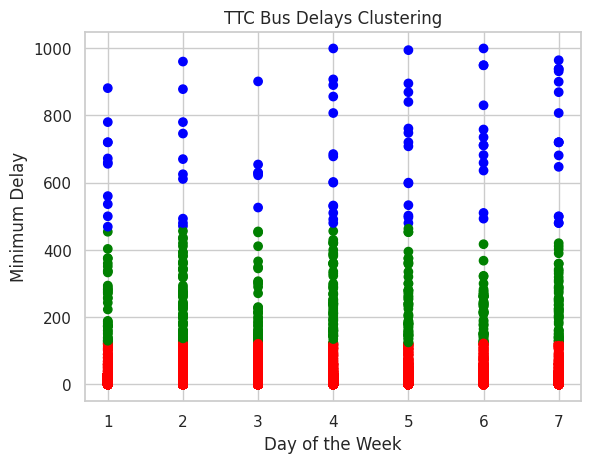

Day with the Fewest Bus Delays: Tuesday


In [ ]:
# Calculate the number of bus delays in each cluster
cluster_counts = predictions.groupBy("prediction").count()

# Find the cluster with the fewest delays
cluster_with_fewest_delays = cluster_counts.orderBy("count").limit(1).select("prediction").first()[0]

# Find the corresponding day
day_with_fewest_delays = predictions.filter(predictions["prediction"] == cluster_with_fewest_delays).
groupBy("Day").count().orderBy("count").limit(1).select("Day").first()[0]
print("Day with the Fewest Bus Delays:", day_with_fewest_delays)


colors = ['red', 'blue', 'green']

# Plot the clusters
data_pd = predictions.select("day_num", "Min Delay", "prediction").toPandas()
plt.scatter(data_pd["day_num"], data_pd["Min Delay"],  c=[colors[i] for i in data_pd["prediction"]])
plt.xlabel("Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Minimum Delay")
plt.title("TTC Bus Delays Clustering")
plt.show()

print("Day with the Fewest Bus Delays:", day_with_fewest_delays)

In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Create a ClusteringEvaluator object
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', metricName='silhouette')

# Calculate the silhouette score
silhouette_score = evaluator.evaluate(predictions)

# Print the silhouette score
print("Silhouette score:", silhouette_score)


Silhouette score: 0.9830815076684387


In [ ]:
 #Can we identify patterns or groupings in bus delays based on the month and the duration of delays (Min Delay)?

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.sql.functions import month
import pyspark.sql.functions as F

# Load the dataset
data_3 = spark.read.csv("/content/drive/MyDrive/DataSet/ttc-bus-delay-data-2022.csv", header=True, inferSchema=True)

# Convert the "Date" column to a date format
data_3 = data_3.withColumn("Date", F.to_date(col("Date"), "d-MMM-yy"))

# Extract month from the "Date" column
data_3 = data_3.withColumn("Month", month(data_3["Date"]))

# Convert the "Month" and "Min Delay" columns to numerical types
data_3 = data_3.withColumn("Month", data_3["Month"].cast("double"))
data_3 = data_3.withColumn("Min Delay", data_3["Min Delay"].cast("double"))



In [ ]:

from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

# Select the columns to use for clustering
feature_columns = ["Month", "Min Delay"]

# Assemble the features into a vector column
assembler_3 = VectorAssembler(inputCols=feature_columns, outputCol="features")
data_3 = assembler_3.transform(data_3)



In [ ]:
# Calculate the average delay for each month
average_delay_by_month = data_3.groupBy("Month").agg({"Min Delay": "avg"})

# Sort the results by average delay
average_delay_by_month = average_delay_by_month.orderBy("avg(Min Delay)")

# Print the results
average_delay_by_month.show()

+-----+------------------+
|Month|    avg(Min Delay)|
+-----+------------------+
|  3.0|17.632189582819056|
|  4.0|18.573475831916443|
|  1.0|19.849727705922398|
|  6.0|19.998351535132908|
|  5.0| 20.79120142920947|
|  2.0|25.275402414486923|
+-----+------------------+



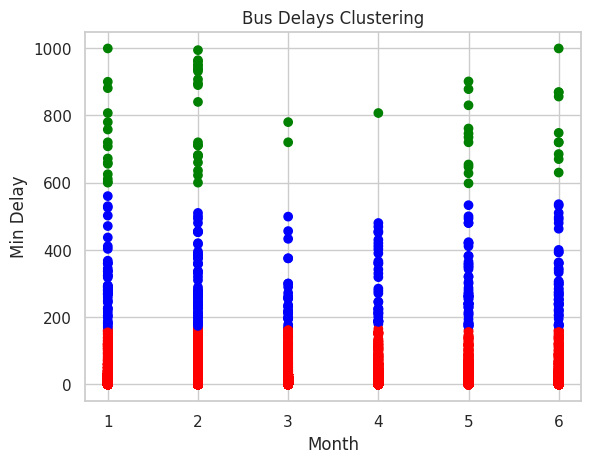

In [ ]:
# Train a hierarchical clustering model
agg_clustering = AgglomerativeClustering(n_clusters=3, linkage='ward')
data_pd = data_3.select("Month", "Min Delay").toPandas()
cluster_labels = agg_clustering.fit_predict(data_pd)

# Add the cluster labels as a new column
data_pd["Cluster"] = cluster_labels

colors = ['red', 'blue', 'green']

# Visualize the clusters
plt.scatter(data_pd["Month"], data_pd["Min Delay"],c=[colors[i] for i in data_pd["Cluster"]])
plt.xlabel("Month")
plt.ylabel("Min Delay")
plt.title("Bus Delays Clustering")
plt.show()



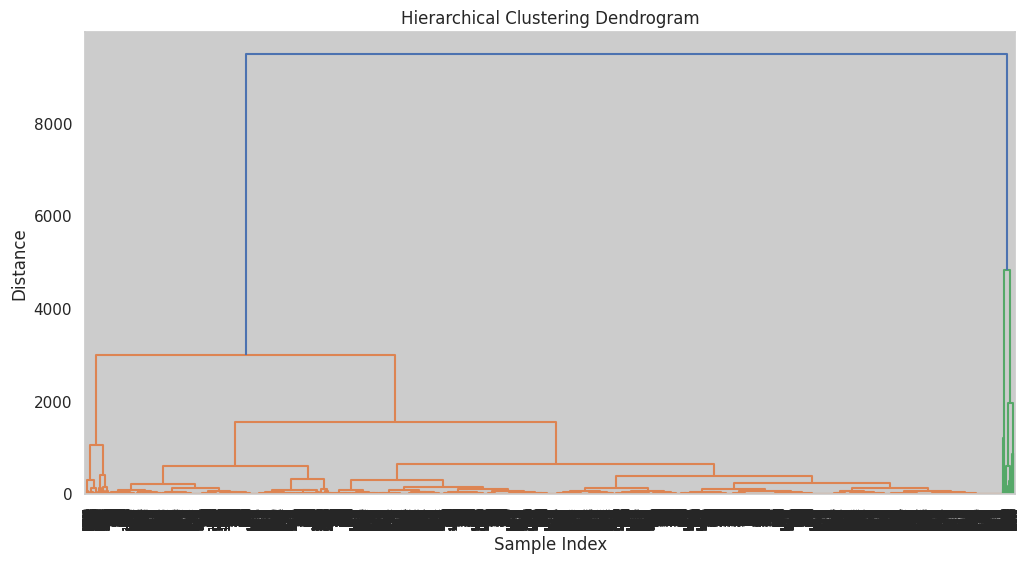

In [ ]:
# Create linkage matrix
linkage_matrix = linkage(data_pd[["Month", "Min Delay"]], method='ward')

# Create a dendrogram with adjusted figure size
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, orientation='top')
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [ ]:
###How can we identify groups of bus routes that have similar distribution of bus delays?

In [ ]:
# Import necessary libraries
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder.getOrCreate()

# Read the TTC Bus Delay dataset
data4 = spark.read.csv("/content/drive/MyDrive/DataSet/ttc-bus-delay-data-2022.csv", header=True, inferSchema=True)

# Select the "route" and "min delay" columns
selected_data = data4.select("route", "min delay")

# Pivot the data to get the minimum delay time distribution for each route
pivoted_data = selected_data.groupBy("route").pivot("min delay").count().na.fill(0)

# Assemble the features into a vector
assembler = VectorAssembler(inputCols=pivoted_data.columns[1:], outputCol="features")
assembled_data = assembler.transform(pivoted_data)

# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaled_data = scaler.fit(assembled_data).transform(assembled_data)

# Train the K-means clustering model
kmeans = KMeans(k=5, seed=1)
model = kmeans.fit(scaled_data)

# Get the cluster labels for each route
clustered_data = model.transform(scaled_data)

# Evaluate the clustering accuracy
silhouette_score = model.summary.clusterSizes
print("Silhouette Score:", silhouette_score)



Silhouette Score: [32, 189, 1, 1, 1]


In [ ]:
#Which routes have similar patterns of minimum delays?

In [ ]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import GaussianMixture


# Read the TTC bus delay dataset
df =  spark.read.csv("/content/drive/MyDrive/DataSet/ttc-bus-delay-data-2022.csv", header=True, inferSchema=True)


# Select the 'Route' and 'Min Delay' columns
selected_df = df.select('Route', 'Min Delay')

# Drop rows with missing values
selected_df = selected_df.na.drop()

# Convert the 'Min Delay' column to float
selected_df = selected_df.withColumn('Min Delay', selected_df['Min Delay'].cast('float'))

# Assemble the features into a vector
assembler = VectorAssembler(inputCols=['Min Delay'], outputCol='features')
assembled_df = assembler.transform(selected_df)

# Fit a Gaussian Mixture Model with 5 clusters
gmm = GaussianMixture(k=5, seed=42)
model = gmm.fit(assembled_df)

# Add the predicted cluster labels to the original dataframe
predictions = model.transform(assembled_df)

# Show the route, minimum delay, and predicted cluster label
predictions.select('Route', 'Min Delay', 'prediction').show()


+-----+---------+----------+
|Route|Min Delay|prediction|
+-----+---------+----------+
|  320|      0.0|         1|
|  325|    131.0|         2|
|  320|     17.0|         3|
|  320|      4.0|         1|
|  320|      4.0|         1|
|  363|     30.0|         3|
|   96|      0.0|         1|
|  320|      4.0|         1|
|  320|      4.0|         1|
|  300|      0.0|         1|
|  300|     17.0|         3|
|   47|     15.0|         3|
|   45|     30.0|         3|
|   32|     16.0|         3|
|   32|      0.0|         1|
|   39|     30.0|         3|
|   32|     30.0|         3|
|   53|     30.0|         3|
|   29|     10.0|         4|
|  334|     33.0|         3|
+-----+---------+----------+
only showing top 20 rows



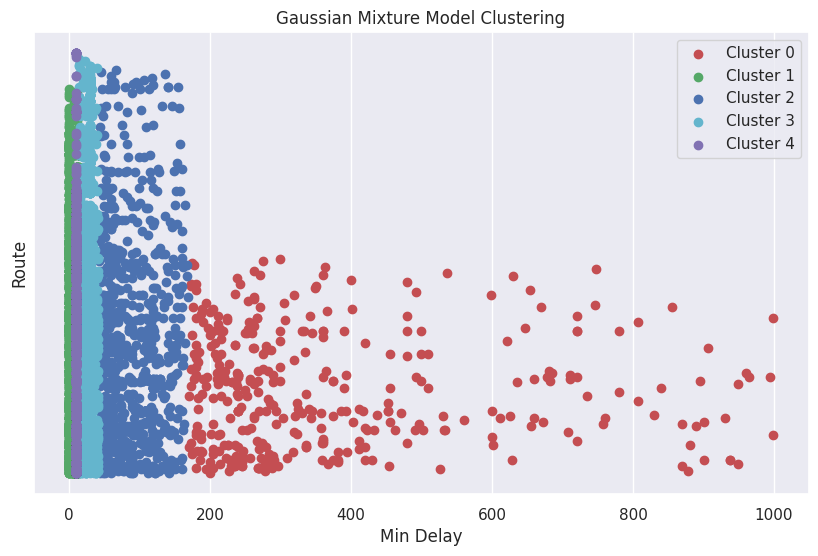

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Collect the data into a Pandas DataFrame
results = predictions.select('Route', 'Min Delay', 'prediction').toPandas()

# Define a color map for the clusters
colors = ['r', 'g', 'b', 'c', 'm']

# Create a scatter plot
plt.figure(figsize=(10, 6))
for i in range(5):  # Assuming you have 5 clusters
    cluster_data = results[results['prediction'] == i]
    plt.scatter(cluster_data['Min Delay'], cluster_data['Route'], label=f'Cluster {i}', color=colors[i])

plt.xlabel('Min Delay')
plt.ylabel('Route')  # Add the y-axis label
plt.title('Gaussian Mixture Model Clustering')
plt.legend()
plt.yticks([])  # Hide y-axis labels

plt.show()


In [ ]:

# Get the cluster centers
cluster_centers = model.gaussians
cluster_centers = [g.mean.toArray() for g in cluster_centers]

# Print the cluster centers and the number of routes in each cluster
print("Cluster centers:")
for i in range(len(cluster_centers)):
    cluster_counts = predictions.where(predictions['prediction'] == i).count()
    print("Cluster {}: {} ({})".format(i, cluster_centers[i], cluster_counts))

Cluster centers:
Cluster 0: [328.20039655] (358)
Cluster 1: [8.86909839] (12317)
Cluster 2: [74.9378463] (874)
Cluster 3: [19.87592506] (9324)
Cluster 4: [10.] (4314)


In [ ]:
# Select the routes in Cluster 0
cluster_0_routes = predictions.select('Route').where(predictions['prediction'] == 0).collect()

# Extract the routes and format them as a comma-separated string
cluster_0_routes_str = ", ".join([str(route[0]) for route in cluster_0_routes])

# Print the routes in Cluster 0
print("Cluster 0 (high minimum delays):")
print(cluster_0_routes_str)


Cluster 0 (high minimum delays):
89, 40, 70, 320, 97, 320, 39, 320, 75, 121, 300, 320, 939, 17, 17, 320, 46, 47, 78, 63, 161, 52, 59, 109, 92, 96, 63, 112, 53, 36, 39, 65, 59, 161, 300, 95, 161, 63, 88, 161, 82, 8, 82, 87, 96, 64, 78, 66, 77, 14, 106, 106, 59, 165, 960, 64, 59, 161, 88, 87, 16, 169, 82, 354, 56, 67, 37, 10, 14, 109, 82, 63, 14, 71, 55, 46, 77, 118, 161, 55, 14, 14, 62, 108, 94, 19, 13, 33, 107, 97, 26, 363, 19, 13, 13, 94, 88, 21, 47, 69, 95, 13, 35, 56, 13, 79, 94, 93, 13, 121, 121, 75, 53, 97, 37, 336, 107, 97, 320, 97, 169, 121, 104, 14, 41, 46, 77, 64, 100, 11, 20, 25, 95, 14, 54, 19, 97, 14, 26, 19, 300, 87, 300, 133, 320, 98, 90, 20, 108, 118, 55, 39, 121, 41, 939, 39, 129, 116, 905, 29, 94, 13, 108, 108, 300, 19, 94, 134, 68, 33, 98, 86, 63, 41, 13, 97, 29, 94, 94, 41, 36, 112, 118, 112, 94, 29, 119, 110, 112, 43, 32, 29, 41, 47, 32, 168, 168, 29, 75, 1, 16, 96, 46, 47, 75, 925, 29, 29, 76, 40, 42, 36, 78, 161, 55, 13, 110, 110, 42, 12, 121, 65, 121, 53, 29, 120